In [1]:
import pandas as pd
from scipy.io import arff

from utils import dataset_to_time_series

In [2]:
data = arff.loadarff("toy-train.arff")
dataFrame = pd.DataFrame(data[0])
dataFrame = dataFrame['gyro_yaw']

In [3]:
# data slice of the first two laps
nTwoLaps = 530
df2Laps = dataFrame[:nTwoLaps]

In [4]:
# I consider nPast number of steps from past into my time series features,
# also make my time series to consist of nFuture number of targets,
nPast = 3
nFuture = 11
df2LapsTimeseries = dataset_to_time_series(df2Laps, nPast, nFuture)

In [5]:
# (number of) Features consist of nPast number of columns representing past, plus one column representing preset
# Target contains nFuture number of columns representing future
nFeature = nPast + 1

X = df2LapsTimeseries.iloc[:, :nFeature]
y = df2LapsTimeseries.iloc[:, nFeature:]

In [6]:
from sklearn.model_selection import train_test_split

testSize = 0.1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testSize, shuffle=False)

In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_trainScaler = scaler.fit_transform(X_train)
X_testScaler = scaler.transform(X_test)

In [8]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100)
model.fit(X_trainScaler, y_train)

RandomForestRegressor()

In [9]:
predictionsRF = model.predict(X_testScaler)

In [10]:
from sklearn.metrics import mean_absolute_error

maeTestAll = mean_absolute_error(y_test, predictionsRF)
print("mean absolute error of all is", maeTestAll)

maeTestT1 = mean_absolute_error(y_test.iloc[:, 0], predictionsRF[:, 0])
print("mean absolute error of t+1 is", maeTestT1)

maeTestT10 = mean_absolute_error(y_test.iloc[:, 9], predictionsRF[:, 9])
print("mean absolute error of t+10 is", maeTestT10)

mean absolute error of all is 3.8803588461538325
mean absolute error of t+1 is 1.4400269230768774
mean absolute error of t+10 is 5.80197884615381


In [11]:
y_test = y_test.reset_index(drop=True)

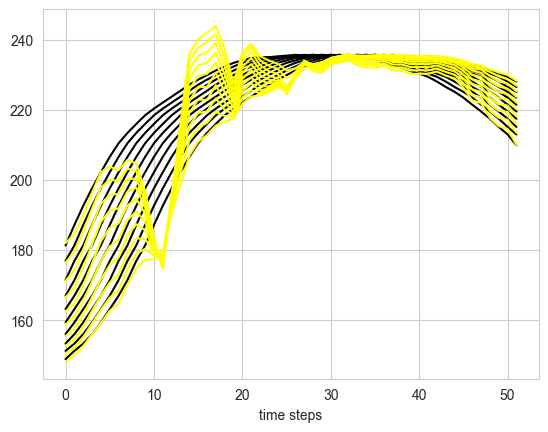

In [12]:
import matplotlib.pyplot as plt

plt.plot(y_test, color='black')
plt.plot(pd.DataFrame(predictionsRF), color='yellow')
plt.xlabel('time steps')

plt.show()

# Unseen data
The last 6 laps.

In [13]:
afterSecondRoundData = dataFrame[nTwoLaps:]
afterSecondRoundDataTimeseries = dataset_to_time_series(afterSecondRoundData, nPast, nFuture)

In [14]:
nFeature = nPast + 1

X_unseen = afterSecondRoundDataTimeseries.iloc[:, :nFeature]
y_unseen = afterSecondRoundDataTimeseries.iloc[:, nFeature:]

In [15]:
X_unseenScaler = scaler.transform(X_unseen)

In [16]:
predictionsUnseenRF = model.predict(X_unseenScaler)

In [17]:
maeUnseenAll = mean_absolute_error(y_unseen, predictionsUnseenRF)
print("mean absolute error of all steps is", maeUnseenAll)

maeUnseenT1 = mean_absolute_error(y_unseen.iloc[:, 0], predictionsUnseenRF[:, 0])
print("mean absolute error of t+1 is", maeUnseenT1)

maeUnseenT10 = mean_absolute_error(y_unseen.iloc[:, 9], predictionsUnseenRF[:, 0])
print("mean absolute error of t+10 is", maeUnseenT10)

mean absolute error of all steps is 4.989556489955349
mean absolute error of t+1 is 1.711495256696422
mean absolute error of t+10 is 16.262611328124976


In [18]:
y_unseen = y_unseen.reset_index(drop=True)

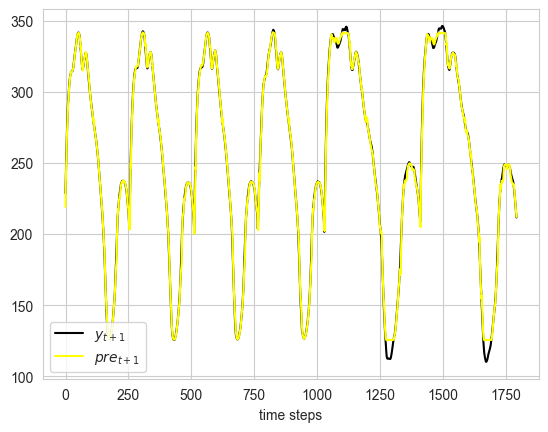

In [19]:
plt.plot(y_unseen.iloc[:, 0], color='black', label='$y_{t+1}$')
plt.plot(predictionsUnseenRF[:, 0], color='yellow', label='$pre_{t+1}$')
plt.legend()
plt.xlabel('time steps')

plt.show()

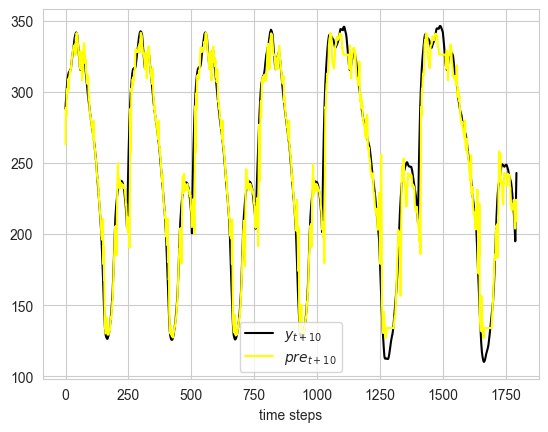

In [20]:
plt.plot(y_unseen.iloc[:, 9], color='black', label='$y_{t+10}$')
plt.plot(predictionsUnseenRF[:, 9], color='yellow', label='$pre_{t+10}$')
plt.legend()
plt.xlabel('time steps')

plt.show()

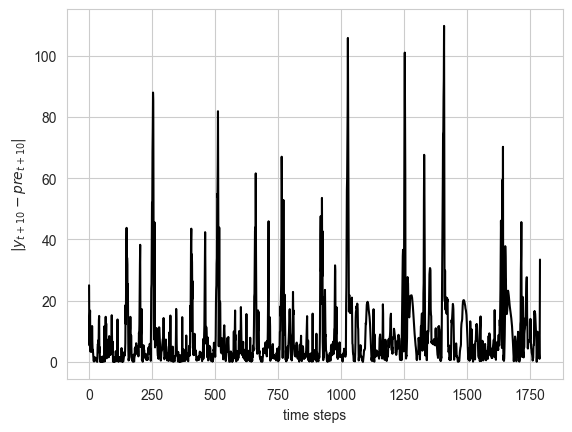

In [21]:
plt.plot(abs(y_unseen.iloc[:, 9] - predictionsUnseenRF[:, 9]), color='black')
plt.xlabel('time steps')
plt.ylabel('$|y_{t+10} - pre_{t+10}|$')

plt.show()

In [22]:
diffUnseenT10 = abs(y_unseen.iloc[:, 9] - predictionsUnseenRF[:, 9])

In [23]:
# I decide to compare the difference between the predicted value and actual value with a constant error.
delta = 7

chart = pd.DataFrame(index=range(0, len(diffUnseenT10)), columns=['status'])
for i in range(len(diffUnseenT10)):
    if diffUnseenT10[i] <= delta:
        chart['status'].iloc[i] = 'normal'
    else:
        chart['status'].iloc[i] = 'fail'
chart

,status
0,fail
1,fail
2,normal
3,fail
4,fail
...,...
1787,fail
1788,normal
1789,normal
1790,fail


In [24]:
chart['status'].value_counts()

normal    1174
fail       618
Name: status, dtype: int64